In [16]:
try:
  import livelossplot
except ModuleNotFoundError:
  !pip install livelossplot -q

In [17]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from livelossplot.inputs.keras import PlotLossesCallback

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
use_model = VGG16
model_name = "VGG16"
preprocessing = preprocess_input_vgg16

#use_model = EfficientNetB0
#model_name = "EfficientNetB0"
#preprocessing = preprocess_input_efficientnet

#use_model = ResNet50
#model_name = "ResNet50"
#preprocessing = preprocess_input_resnet

In [20]:
data_path = "/content/drive/MyDrive/CAFO_data/forTraining/"

# Code does not do anything about the fact that Iowa and Mexico have
# many more farms and not-farms than the other datasets
datasets = ["chl", "rou", "iowa"]

gdf_list = []
for place in datasets:
  gdf = pd.read_pickle(f'{data_path}{place}_final.pkl')
  print(f"There are {len(gdf)} rows in the {place} dataset")
  if place in ["iowa"]:
    #print(f" -- Sampling all not-farms and 1000 farms from {place} dataset")
    #gdf1 = gdf[gdf["Farm type"] == "Non-farm"]
    #gdf2 = gdf[gdf["Farm type"] != "Non-farm"].sample(1000)
    #gdf = pd.concat([gdf1, gdf2])
    print("Sampling 1500 rows from the Iowa dataset")
    gdf = gdf.sample(1500)
    print(len(gdf))
  gdf_list.append(gdf)

data = pd.concat(gdf_list).reset_index(drop=True)

There are 664 rows in the chl dataset
There are 809 rows in the rou dataset
There are 6532 rows in the iowa dataset
Sampling 1500 rows from the Iowa dataset
1500


In [21]:
images = []
labels = []
metadata_list = []

for idx, row in data.iterrows():
  # Glomming all farm types into a single "CAFO" class
  if row['Farm type'] in ["Poultry", "Broiler", "Layer", "Pig", "Unknown CAFO"]:
    labels.append("CAFO")
    images.append(row["Sentinel"])
  elif row['Farm type'] == "Non-farm":
    labels.append("Non-farm")
    images.append(row["Sentinel"])
  else:
    print(f"Unexpected farm type, {row['Farm type']}")
  metadata_list.append(row.drop(["Sentinel"]).to_dict())

# Labels --> categorical --> one hot
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels, num_classes=len(set(labels)))

class_mapping = dict(zip(encoded_labels, labels))
print("Class mapping:", class_mapping)
n_classes = len(class_mapping)

# Recombine images, labels, and metadata into a DataFrame for shuffling
data1 = list(zip(images, one_hot_labels, metadata_list))
df = pd.DataFrame(data1, columns=['image', 'label', 'metadata'])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Class mapping: {1: 'Non-farm', 0: 'CAFO'}


In [22]:
# Create training, validation, and test datasets

# Split into (training+validation) and test sets (10% for testing)
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Split training + validation into training and validation sets (~20% for val)
train_df, val_df = train_test_split(train_val_df, test_size=0.22,\
                                    random_state=42)

# Extract the split data
X_train = np.array(train_df['image'].tolist())
y_train = np.array(train_df['label'].tolist())

X_val = np.array(val_df['image'].tolist())
y_val = np.array(val_df['label'].tolist())

X_test = np.array(test_df['image'].tolist())
y_test = np.array(test_df['label'].tolist())

# The index of each item in X_train etc. should correspond to the index in
# the appropriate dataframe
metadata_train = pd.json_normalize(train_df['metadata'])
metadata_val = pd.json_normalize(val_df['metadata'])
metadata_test = pd.json_normalize(test_df['metadata'])

# Print the number of training, validation, and test images
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Keep copies of original data as the arrays can get changed by the data
# generators (this should be handled differently?)
X_train_original = np.copy(X_train)
X_val_original = np.copy(X_val)
X_test_original = np.copy(X_test)

Training set: 2086 images
Validation set: 589 images
Test set: 298 images


In [23]:
# Set up data generators, augmenting training data but not validation + test data

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocessing
    )

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing
    )

In [24]:
# Create the model so as to fine-tune only the top 2 (non-convolutional) layers
# This is essentially extracting existing features and re-learning how to
# classify based on them

input_shape=X_train.shape[1:]
optimizer=Adam(learning_rate=0.001)
weights_file = f'/content/drive/MyDrive/CAFO_models/better{model_name}_step1.keras'

# Load pretrained layers, excluding fully-connected layers
base_model = use_model(include_top=False,
                  weights='imagenet',
                  input_shape=input_shape)

# Freeze pretrained layers
base_model.trainable = False
top_model = base_model.output

if use_model == VGG16:
  # Create new fully-connected layers for classification
  top_model = Flatten(name="flatten")(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(256, activation='relu')(top_model)
  top_model = Dropout(0.5)(top_model)
  output_layer = Dense(n_classes, activation='softmax')(top_model)

elif use_model in [EfficientNetB0, ResNet50]:
  top_model = GlobalAveragePooling2D()(top_model)
  output_layer = Dense(n_classes, activation='softmax')(top_model)

else:
  raise ValueError(f"Unknown model {use_model}")

# Combine the base (convolutional) and top (fully-connected) layers
model = Model(inputs=base_model.input, outputs=output_layer)

# If we have already done this step, can load saved weights from file
if weights_file is not None:
  print(f'Loading model from {weights_file}')
  model.load_weights(weights_file)

# Compile the model for training.
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Loading model from /content/drive/MyDrive/CAFO_models/betterVGG16_step1.keras


In [25]:
# Define early stopping + other callbacks.

lr = ReduceLROnPlateau(
                      factor=0.5,
                      monitor='val_loss',
                      min_delta=0,
                      patience=3,
                      min_lr=1e-6,
                      verbose=2
                      )

es = EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  restore_best_weights=True,
                  min_delta=0,
                  patience=4, #reduced from 6
                  verbose=2
                  )

mc = ModelCheckpoint(
                    f'/content/drive/MyDrive/CAFO_models/better{model_name}_step1.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=2,
                    save_best_only=True
                    )

pl = PlotLossesCallback()

In [26]:
# Fit the model, if we haven't reloaded a previously-fitted one

if weights_file is None:

  history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=50,
                    callbacks=[lr, es, mc, pl],
                    verbose=2
                    )

In [27]:
# Use the model to make predictions for the test data. As
# EarlyStopping.restore_best_weights=True, this should be the best model,
# not just the final epoch's one

results = utils.get_predictions(model, X_test, y_test, model_name, metadata_test)

# Generate sklearn classification report
print('\n', classification_report(results["Label"].to_list(),\
                                  results['Model Class'].to_list()))

# Show some of the correctly- and incorrectly-classified images. Use the
# "ascending" kw to say whether the images should be arranged in order
# of ascending probability (True/False)

utils.plot_classified_images(X_test, results, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

In [28]:
# Fine-tune the model

# Set the top block to be trainable
for layer in base_model.layers:
    if use_model == VGG16 and 'block5' in layer.name:
        layer.trainable = True
        print(f"Layer {layer.name} is trainable")
    elif use_model == EfficientNetB0 and 'block7a' in layer.name:
        layer.trainable = True
        print(f"Layer {layer.name} is trainable")
    elif use_model == ResNet50 and "conv5" in layer.name:
        layer.trainable = True
        print(f"Layer {layer.name} is trainable")

# Compile the model with a lower learning rate
# Model compiling does not change weights; see
# stackoverflow.com/questions/47995324/does-model-compile-initialize-all-the-
# weights-and-biases-in-keras-tensorflow
optimizer=Adam(learning_rate=0.001*0.2)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Update parameters for Reduce LR and EarlyStopping to reduce overfitting
lr = ReduceLROnPlateau(
                      factor=0.5,
                      monitor='val_loss',
                      min_delta=0.03,
                      patience=3,
                      min_lr=1e-6,
                      verbose=2
                      )

es = EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  restore_best_weights=True,
                  min_delta=0.02, #reduced from 0.03
                  patience=4, #reduced from 6
                  verbose=2
                  )

# Specify a new filename for best model
mc = ModelCheckpoint(
                    f'/content/drive/MyDrive/CAFO_models/better{model_name}_step2.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=2,
                    save_best_only=True
                    )

# Reset the plots
pl = PlotLossesCallback()

Layer block5_conv1 is trainable
Layer block5_conv2 is trainable
Layer block5_conv3 is trainable
Layer block5_pool is trainable


In [29]:
weights_file = f'/content/drive/MyDrive/CAFO_models/better{model_name}_step2.keras'

if weights_file is not None:
  # Skip fine-tuning and proceed to examine results from existing fine-tuned
  # model
  print(f'Loading weights from {weights_file}')
  model.load_weights(weights_file) #load weights or whole model?

else:

  # Uncomment if this fine-tuning step is interrupted and restarted
  # Otherwise I'm not sure where fitting will start from
  #weights_file = f'/content/drive/MyDrive/CAFO_models/better{model_name}_step1.keras'
  #model.load_weights(weights_file)

  # Fit the model
  ft_history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=70, #base epochs + fine-tuning ones?
                    callbacks=[lr, mc, es, pl],
                    verbose=2
                    )

Loading weights from /content/drive/MyDrive/CAFO_models/betterVGG16_step2.keras


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [30]:
results_ft = utils.get_predictions(model, X_test, y_test, model_name, metadata_test)

print('\n', classification_report(results_ft["Label"].to_list(),\
                                  results_ft['Model Class'].to_list()))

utils.plot_classified_images(X_test, results_ft, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

In [118]:

def select_test_image(prediction, label, probability_range=(0.99, 1.0)):
  """
  Return a randomly-selected image matching the stated criteria, and a version
  preprocessed for the relevant model.
  """

  # Some prep work
  df = pd.DataFrame()
  df['Probability_0'] = results_ft['Model Probabilities'].apply(lambda x: x[0])
  df['Probability_1'] = results_ft['Model Probabilities'].apply(lambda x: x[1])
  df['Label'] = results_ft['Label']

  # Select an image matching criteria
  df = df[df["Label"] == label]
  if prediction == label:
    df = df[df["Label"] == prediction]
  else:
    df = df[df["Label"] != prediction]

  df = df[(df[f'Probability_{str(prediction)}'] > probability_range[0]) &\
          (df[f'Probability_{str(prediction)}'] <= probability_range[1])]

  print(f"Sampling one of {len(df)} images")
  test_idx = df.sample(1).index.values[0]
  test_img = X_test[test_idx]

  # Create a version that is scaled for imshow
  img = ((test_img / np.max(test_img)) * 255).astype("uint8")

  # Create a version that is preprocessed in the same way as the training data
  preprocessed_image = preprocessing(test_img)  # Preprocess the image
  preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension

  return img, preprocessed_image

In [45]:
def get_gradcam_heatmap(model, image, last_conv_layer_name, class_index):

    # Create a model that outputs the feature map and predictions
    grad_model = Model([model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output])

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)  # Forward pass
        loss = predictions[:, class_index]  # Get the prediction for the target class

    # Calculate gradients with respect to the chosen class
    grads = tape.gradient(loss, conv_outputs)

    # Calculate the mean intensity of the gradients over the width and height
    # This gives the "importance" of each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by its importance
    conv_outputs = conv_outputs[0]  # Remove the batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Apply ReLU to the heatmap (only keep positive values)
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap to range [0, 1]
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap

def display_gradcam(image, heatmap, alpha=0.5):
    # Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert the heatmap to an RGB color map
    heatmap_colored = plt.get_cmap("jet")(heatmap_resized)

    # Display the original image
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.axis("off")

    # Overlay the Grad-CAM heatmap
    plt.subplot(2, 2, 2)
    plt.imshow(image)
    plt.imshow(heatmap_colored, alpha=alpha)
    plt.axis("off")

    # Same with a contrast-adjusted image
    plt.subplot(2, 2, 3)
    adjusted = cv2.convertScaleAbs(image, alpha=3, beta=1)
    plt.imshow(adjusted)
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(adjusted)
    plt.imshow(heatmap_colored, alpha=alpha)
    plt.axis("off")

    plt.tight_layout()

Sampling one of 125 images


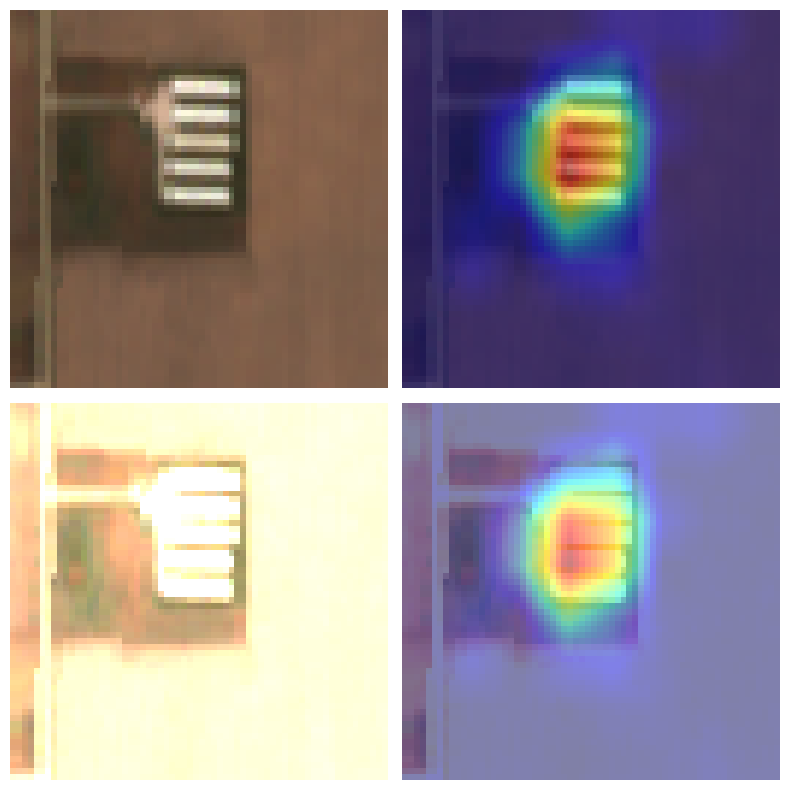

In [122]:
# Define the last convolutional layer based on the model type
last_conv_layer_name = 'block4_conv3' if use_model == VGG16 else 'top_conv'

# Get a test image
prediction = 0
label = 0
image, preprocessed_image = select_test_image(prediction, label, (0.5, 1.0))

# Create and display its Grad-CAM heatmap
heatmap = get_gradcam_heatmap(model, preprocessed_image, last_conv_layer_name,\
                              prediction)
display_gradcam(image, heatmap, alpha=0.5)